Removed First row from the PPG-BP dataset xlsx file
Converted new xlsx to CSV for faster execution
New CSV file named as SubjectData.csv
PPGBPDatabase folder contains all the ppg cycle of the subjects in TXT format

In [51]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy.signal import savgol_filter
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

## Importing SubjectData CSV file using Pandas

In [52]:
SubjectData=pd.read_csv('SubjectData.csv')
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.27,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.28,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.89,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.97,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.06,Prehypertension,NaN,NaN,NaN


### Data Cleaning
Label encoding - converting the labels into numerical format <br>
Such as <br>
Encoding NaN with 0 in Cerebral Infarction and 'cerebral infarction' as 1 <br>
0 = No Cerebral Infarction <br>
1 = Cerebral Infarction

In [53]:
label_encoder = preprocessing.LabelEncoder()
SubjectData['cerebral infarction']= label_encoder.fit_transform(SubjectData['cerebral infarction'])
SubjectData['Hypertension']= label_encoder.fit_transform(SubjectData['Hypertension'])
SubjectData['Diabetes']= label_encoder.fit_transform(SubjectData['Diabetes'])
SubjectData['cerebrovascular disease']= label_encoder.fit_transform(SubjectData['cerebrovascular disease'])
SubjectData['Sex(M/F)']= label_encoder.fit_transform(SubjectData['Sex(M/F)'])

In [54]:
countCI=SubjectData['cerebral infarction'].value_counts()
print('Total number of subjects :',countCI[1]+countCI[0])
print('Total number of subjects with CI:',countCI[0])
print('Total number of subjects without CI:',countCI[1])

Total number of subjects : 219
Total number of subjects with CI: 20
Total number of subjects without CI: 199


### Importing PPG Cycle of the Target Patients in a dictionary


In [55]:
baseurl='PPGBPDatabase/'
PPGCycle={}
for i in range(420):
    try:
        temp=[]
        for j in range(1,4):
            f=open(baseurl+f'{i}_{j}.txt','r')
            data=f.readline()
            data=data.split('\t')
            data=data[0:-1]
            data=list(map(int,list(map(float,data))))
            # data=list(savgol_filter(data,51,3))
            f.close()
            temp.append(data)  
        PPGCycle[str(i)]=temp
    except:
        continue

## Sample Ploting of PPG Cycle of Subject 2

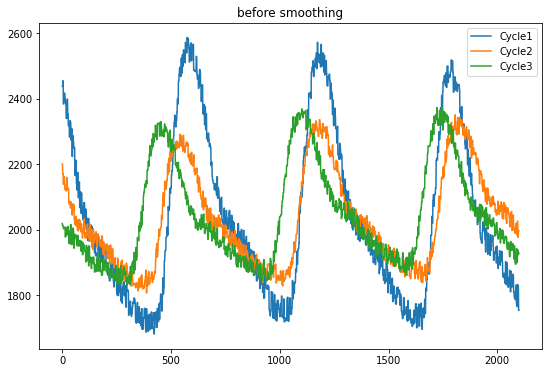

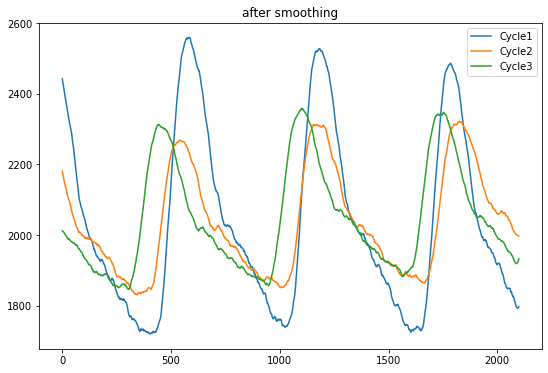

In [56]:
C1=PPGCycle['2'][0]
C2=PPGCycle['2'][1]
C3=PPGCycle['2'][2]
C1Sol=savgol_filter(C1,51,3)
C2Sol=savgol_filter(C2,51,3)
C3Sol=savgol_filter(C3,51,3)
plt.figure(figsize=(9, 6))
plt.title("before smoothing")
plt.plot(C1,label='Cycle1')
plt.plot(C2,label='Cycle2')
plt.plot(C3,label='Cycle3')
plt.legend(['Cycle1','Cycle2','Cycle3'])
plt.show()
plt.figure(figsize=(9, 6))

plt.plot(C1Sol,label='Cycle1')
plt.plot(C2Sol,label='Cycle2')
plt.plot(C3Sol,label='Cycle3')
plt.title("after smoothing")
plt.legend(['Cycle1','Cycle2','Cycle3'])
plt.show()

### Extracting Infromation from the PPGCycle

# Functions to calculate Featues and other values

In [57]:
def Kurt(x):
    size=len(x)
    deviationSq=[]
    deviationSq4=[]
    mean=sum(x)/size
    for i in x:
        deviationSq.append((i-mean)**2)
        deviationSq4.append((i-mean)**4)
    SecondMoment=sum(deviationSq)/size
    FourthMoment=sum(deviationSq4)/size
    Kurtosis=FourthMoment/(SecondMoment**2)
    return Kurtosis

def maxminslope(x):
    max=-math.inf
    min=math.inf
    size=len(x)
    for i in range(size-1):
        if x[i+1]-x[i]>max:
            max=x[i+1]-x[i]
        if x[i+1]-x[i]<min:
            min=x[i+1]-x[i]
    return max,min
def Conf(act,pred):
    size=len(act)
    act=list(map(int,act))
    pred=list(map(int,pred))
    TN=0
    FP=0
    FN=0
    TP=0
    for i in range(size):
        if(act[i]==0 and pred[i]==0):
            TN+=1
        elif(act[i]==0 and pred[i]==1):
            FP+=1
        elif(act[i]==1 and pred[i]==0):
            FN+=1
        elif(act[i]==1 and pred[i]==1):
            TP+=1
    print('TN:',TN)
    print('FP:',FP)
    print('FN:',FN)
    print('TP:',TP)
    print('Precision:',TP/(TP+FP))
    print('Recall:',TP/(TP+FN))
    print('F1 Score:',2*TP/(2*TP+FP+FN))
    sns.heatmap([[TN,FP],[FN,TP]],annot=True,fmt='d')
    return 
        
def Skewness(x):
    size=len(x)
    mean=sum(x)/size
    deviation=[]
    deviationSq=[]
    StandardDeviation=0
    for i in x:
        deviation.append((i-mean))
        deviationSq.append((i-mean)**2)
        StandardDeviation+=(i-mean)**2

    StandardDeviation=(StandardDeviation/size)**0.5
    Skewness=0
    for i in deviation:
        Skewness+=(i/StandardDeviation)**3
    Skewness=Skewness*size/(size-1)/(size-2)
    return Skewness


In [58]:
extractPPGCycle={}
CMean=[[],[],[],[]]
CKurtosis=[[],[],[],[]]
CSkewness=[[],[],[],[]]
CMaxSlope=[[],[],[],[]]
CMinSlope=[[],[],[],[]]
CEntropy=[[],[],[],[]]
for i in PPGCycle.keys():
    temp=[]
    alldata=[]
    for j in range(3):
        data=PPGCycle[i][j]
        alldata+=data
        tempdict={}
        tempdict['Mean']=np.mean(data)
        # tempdict['Kurtosis']=kurtosis(data, fisher=False)
        tempdict['Kurtosis']=Kurt(data)
        tempdict['Skewness']=Skewness(data)
        tempdict['MaxSlope'],tempdict['MinSlope']=maxminslope(data)
        tempdict['Entropy']=entropy(data)
        CMean[j].append(tempdict['Mean'])
        CKurtosis[j].append(tempdict['Kurtosis'])
        CSkewness[j].append(tempdict['Skewness'])
        CMaxSlope[j].append(tempdict['MaxSlope'])
        CMinSlope[j].append(tempdict['MinSlope'])
        CEntropy[j].append(tempdict['Entropy'])
        temp.append(tempdict)
    tempdict={}
    tempdict['Mean']=np.mean(alldata)
    tempdict['Kurtosis']=Kurt(alldata)
    tempdict['Skewness']=Skewness(alldata)
    tempdict['MaxSlope'],tempdict['MinSlope']=maxminslope(alldata)
    tempdict['Entropy']=entropy(alldata)
    CMean[3].append(tempdict['Mean'])
    CKurtosis[3].append(tempdict['Kurtosis'])
    CSkewness[3].append(tempdict['Skewness'])
    CMaxSlope[3].append(tempdict['MaxSlope'])
    CMinSlope[3].append(tempdict['MinSlope'])
    CEntropy[3].append(tempdict['Entropy'])
    temp.append(tempdict)
    extractPPGCycle[i]=temp

### Inserting Extracted Data into the SubjectData

In [59]:
SubjectData['C1-Mean']=CMean[0]
SubjectData['C1-Kurtosis']=CKurtosis[0]
SubjectData['C1-Skewness']=CSkewness[0]
SubjectData['C1-MaxSlope']=CMaxSlope[0]
SubjectData['C1-MinSlope']=CMinSlope[0]
SubjectData['C1-Entropy']=CEntropy[0]
SubjectData['C2-Mean']=CMean[1]
SubjectData['C2-Kurtosis']=CKurtosis[1]
SubjectData['C2-Skewness']=CSkewness[1]
SubjectData['C2-MaxSlope']=CMaxSlope[1]
SubjectData['C2-MinSlope']=CMinSlope[1]
SubjectData['C2-Entropy']=CEntropy[1]
SubjectData['C3-Mean']=CMean[2]
SubjectData['C3-Kurtosis']=CKurtosis[2]
SubjectData['C3-Skewness']=CSkewness[2]
SubjectData['C3-MaxSlope']=CMaxSlope[2]
SubjectData['C3-MinSlope']=CMinSlope[2]
SubjectData['C3-Entropy']=CEntropy[2]
SubjectData['C-Mean']=CMean[3]
SubjectData['C-Kurtosis']=CKurtosis[3]
SubjectData['C-Skewness']=CSkewness[3]
SubjectData['C-MaxSlope']=CMaxSlope[3]
SubjectData['C-MinSlope']=CMinSlope[3]
SubjectData['C-Entropy']=CEntropy[3]
#Min Max Kurtosis and Skewness Mean
#Max slope of the line


In [60]:
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,C3-Skewness,C3-MaxSlope,C3-MinSlope,C3-Entropy,C-Mean,C-Kurtosis,C-Skewness,C-MaxSlope,C-MinSlope,C-Entropy
0,1,2,0,45,152,63,161,89,97,27.27,...,0.667033,65,-66,7.647014,2038.692381,2.778840,0.662604,447,-87,8.744048
1,2,3,0,50,157,50,160,93,76,20.28,...,0.422054,49,-48,7.649424,2004.373968,2.013632,0.449374,58,-60,8.747974
2,3,6,0,47,150,47,101,71,79,20.89,...,0.494501,46,-48,7.648496,2013.143492,2.355045,0.504403,68,-135,8.747484
3,4,8,1,45,172,65,136,93,87,21.97,...,0.504060,43,-49,7.649270,2023.992222,2.155941,0.546420,125,-53,8.747848
4,5,9,0,46,155,65,123,73,73,27.06,...,0.474505,64,-54,7.649417,2011.915079,2.074053,0.354313,64,-80,8.748035


### Plotting Heat Map

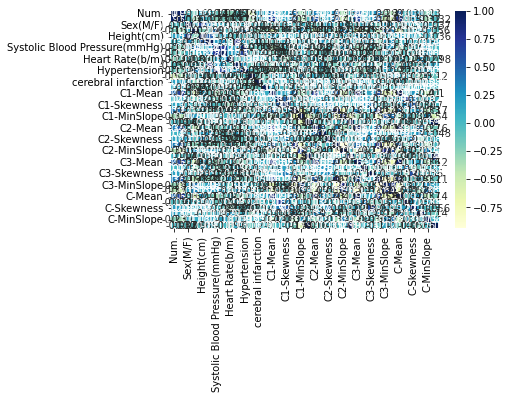

In [61]:
dataplot=sns.heatmap(SubjectData.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Create Training and Test Sets

In [62]:
# X = SubjectData.iloc[:, :-1]
X = SubjectData.drop([
    'subject_ID',
    'cerebral infarction','Height(cm)','Weight(kg)','Age(year)',
    'C-Mean','C-Kurtosis','C-Skewness','C-MaxSlope','C-MinSlope','C-Entropy',
    # 'C1-Mean','C1-Kurtosis','C1-Skewness','C1-MaxSlope','C1-MinSlope','C1-Entropy',
    # 'C2-Mean','C2-Kurtosis','C2-Skewness','C2-MaxSlope','C2-MinSlope','C2-Entropy',
    # 'C3-Mean','C3-Kurtosis','C3-Skewness','C3-MaxSlope','C3-MinSlope','C3-Entropy'
    ],axis=1)
y = SubjectData['cerebral infarction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# X_train=X
# y_train=y

## Data Representation Function


In [63]:
def ClassificationMain(model,modelname,X_test=X_test,y_test=y_test):
    y_pred=model.predict(X_test)
    print(f"For {modelname}")
    scores_accuracy = cross_val_score(model, X, y, cv=20,scoring='accuracy')
    scores_roc_auc = cross_val_score(model, X, y, cv=20,scoring='roc_auc')
    print(classification_report(y_test, y_pred))
    print (f'Accuracy: {scores_accuracy.mean():.2f} +/- {scores_accuracy.std() * 2:.2f}')
    print (f'ROC AUC: {scores_roc_auc.mean():.2f} +/- {scores_roc_auc.std() * 2:.2f}')

    print()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # with labels
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {modelname}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Plotting RUC AUC Curve
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)


    
    # Pyplot ROC Curve
    plt.figure(figsize=(6,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RUC/AUC curve for '+modelname+' model')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc





def test_train_accuracy(model,modelname,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    print(f'Accuracy of {modelname} classifier on training set: {model.score(X_train, y_train):.2f}')
    print(f'Accuracy of {modelname} classifier on test set: {model.score(X_test, y_test):.2f}')



In [64]:


smote = SMOTE(random_state = 2)
# smote = ADASYN(random_state = 2)
adasyn=ADASYN(random_state = 2)
nearMiss = NearMiss()


X_train_over, y_train_over = smote.fit_resample(X_train, y_train.ravel())
X_train_over_ADASYN, y_train_over_ADASYN = adasyn.fit_resample(X_train, y_train.ravel())
X_train_miss, y_train_miss = nearMiss.fit_resample(X_train, y_train.ravel())

print('Original dataset: ')
print(f'Original dataset without cerebral infarction : {sum(y_train==1)}')
print(f'Original dataset with cerebral infarction : {sum(y_train==0)}')
print()
print('After SMOTE: ')
print(f'Over sampled dataset without cerebral infarction : {sum(y_train_over==1)}')
print(f'Over sampled dataset with cerebral infarction : {sum(y_train_over==0)}')
print()
print('After ADASYN: ')
print(f'Original dataset without cerebral infarction : {sum(y_train_over_ADASYN==1)}')
print(f'Original dataset with cerebral infarction : {sum(y_train_over_ADASYN==0)}')
print()
print('After NearMiss: ')
print(f'Under sampled dataset without cerebral infarction : {sum(y_train_miss==1)}')
print(f'Under sampled dataset with cerebral infarction : {sum(y_train_miss==0)}')

Original dataset: 
Original dataset without cerebral infarction : 179
Original dataset with cerebral infarction : 18

After SMOTE: 
Over sampled dataset without cerebral infarction : 179
Over sampled dataset with cerebral infarction : 179

After ADASYN: 
Original dataset without cerebral infarction : 179
Original dataset with cerebral infarction : 184

After NearMiss: 
Under sampled dataset without cerebral infarction : 18
Under sampled dataset with cerebral infarction : 18


## Building Models

### Logistic Regression

In [65]:
LogRegNormal = LogisticRegression(class_weight='balanced')
LogRegOver = LogisticRegression()
LogRegUnder = LogisticRegression()
LogRegNormal.fit(X_train, y_train)
LogRegOver.fit(X_train_over, y_train_over)
LogRegUnder.fit(X_train_miss, y_train_miss)
test_train_accuracy(LogRegNormal,'Logistic Regression Normal')
test_train_accuracy(LogRegOver,'Logistic Regression Over')
test_train_accuracy(LogRegUnder,'Logistic Regression Under')

Accuracy of Logistic Regression Normal classifier on training set: 0.69
Accuracy of Logistic Regression Normal classifier on test set: 0.73
Accuracy of Logistic Regression Over classifier on training set: 0.71
Accuracy of Logistic Regression Over classifier on test set: 0.55
Accuracy of Logistic Regression Under classifier on training set: 0.45
Accuracy of Logistic Regression Under classifier on test set: 0.55


Logistic Regression
For Logistic Regression Normal
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         2
           1       1.00      0.70      0.82        20

    accuracy                           0.73        22
   macro avg       0.62      0.85      0.61        22
weighted avg       0.93      0.73      0.79        22

Accuracy: 0.63 +/- 0.55
ROC AUC: 0.71 +/- 0.51



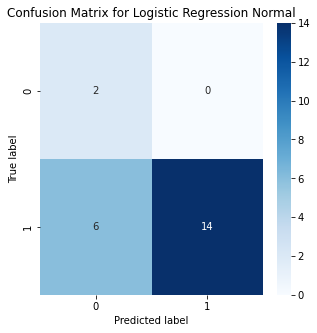

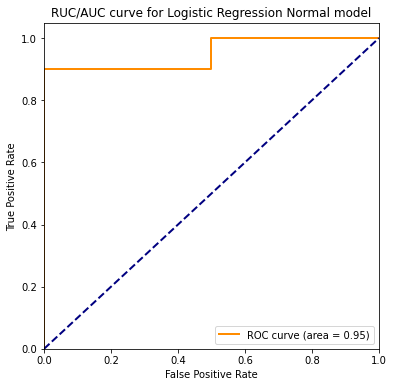

For Logistic Regression Over
              precision    recall  f1-score   support

           0       0.10      0.50      0.17         2
           1       0.92      0.55      0.69        20

    accuracy                           0.55        22
   macro avg       0.51      0.53      0.43        22
weighted avg       0.84      0.55      0.64        22

Accuracy: 0.90 +/- 0.08
ROC AUC: 0.65 +/- 0.49



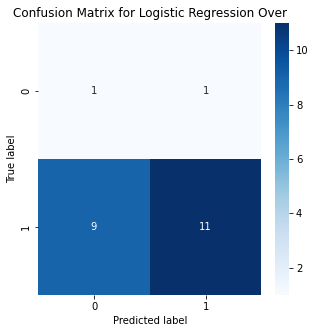

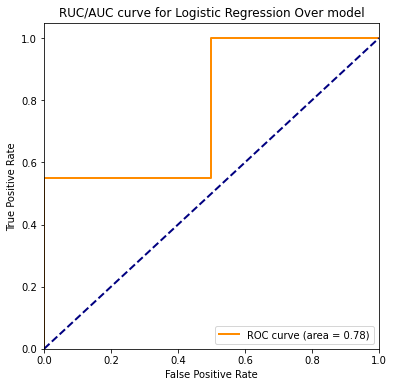

For Logistic Regression Under
              precision    recall  f1-score   support

           0       0.10      0.50      0.17         2
           1       0.92      0.55      0.69        20

    accuracy                           0.55        22
   macro avg       0.51      0.53      0.43        22
weighted avg       0.84      0.55      0.64        22

Accuracy: 0.90 +/- 0.08
ROC AUC: 0.65 +/- 0.49



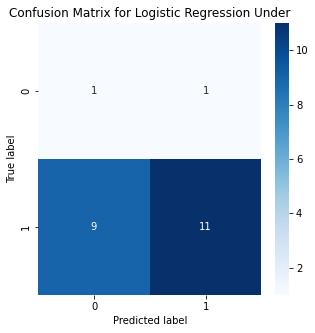

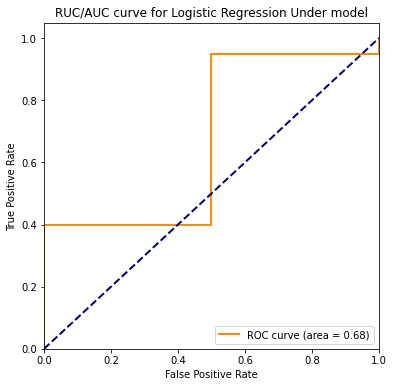

0.675

In [66]:
print("Logistic Regression")
ClassificationMain(LogRegNormal,'Logistic Regression Normal')
ClassificationMain(LogRegOver,'Logistic Regression Over')
ClassificationMain(LogRegUnder,'Logistic Regression Under')


### Decision Tree

In [67]:
DTNormal = DecisionTreeClassifier().fit(X_train, y_train)
DTOver = DecisionTreeClassifier().fit(X_train_over, y_train_over)
DTUnder = DecisionTreeClassifier().fit(X_train_miss, y_train_miss)
test_train_accuracy(DTNormal,'Decision Tree Normal')
test_train_accuracy(DTOver,'Decision Tree Over')
test_train_accuracy(DTUnder,'Decision Tree Under')

Accuracy of Decision Tree Normal classifier on training set: 1.00
Accuracy of Decision Tree Normal classifier on test set: 0.95
Accuracy of Decision Tree Over classifier on training set: 1.00
Accuracy of Decision Tree Over classifier on test set: 0.73
Accuracy of Decision Tree Under classifier on training set: 0.42
Accuracy of Decision Tree Under classifier on test set: 0.55


Decision Tree
For Decision Tree Normal
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.95      1.00      0.98        20

    accuracy                           0.95        22
   macro avg       0.98      0.75      0.82        22
weighted avg       0.96      0.95      0.95        22

Accuracy: 0.84 +/- 0.38
ROC AUC: 0.64 +/- 0.47



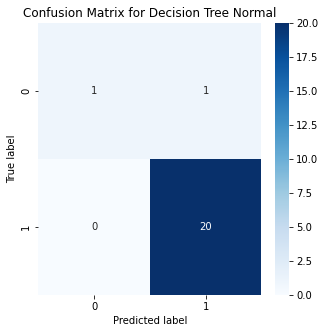

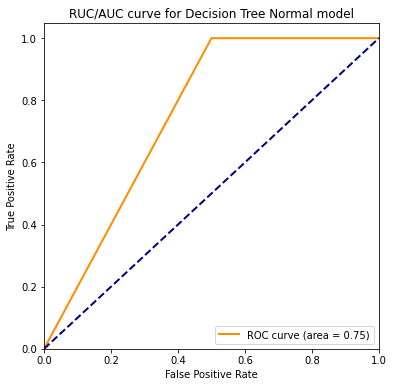

For Decision Tree Over
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      0.80      0.84        20

    accuracy                           0.73        22
   macro avg       0.44      0.40      0.42        22
weighted avg       0.81      0.73      0.77        22

Accuracy: 0.84 +/- 0.41
ROC AUC: 0.66 +/- 0.50



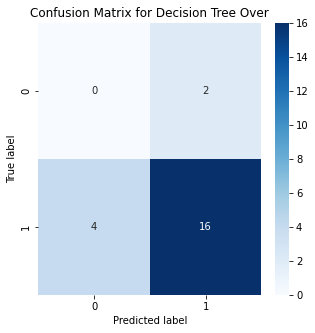

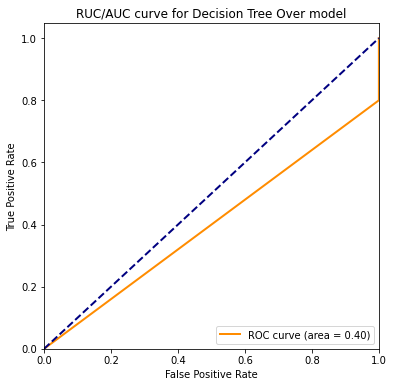

For Decision Tree Under
              precision    recall  f1-score   support

           0       0.10      0.50      0.17         2
           1       0.92      0.55      0.69        20

    accuracy                           0.55        22
   macro avg       0.51      0.53      0.43        22
weighted avg       0.84      0.55      0.64        22

Accuracy: 0.83 +/- 0.40
ROC AUC: 0.69 +/- 0.51



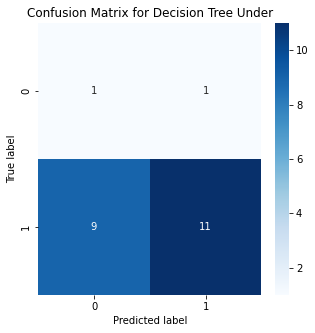

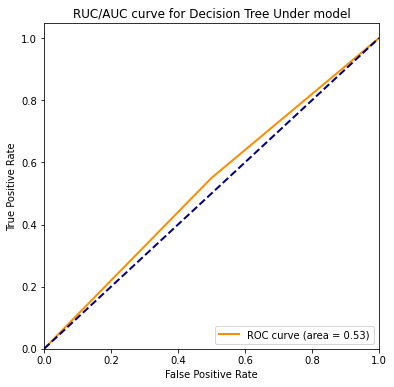

0.525

In [68]:
print("Decision Tree")
ClassificationMain(DTNormal,'Decision Tree Normal')
ClassificationMain(DTOver,'Decision Tree Over')
ClassificationMain(DTUnder,'Decision Tree Under')

### Random Forest

In [69]:
# Random Forest

RFNormal = RandomForestClassifier(n_estimators=100, random_state=2).fit(X_train, y_train)
RFOver = RandomForestClassifier(n_estimators=100, random_state=2).fit(X_train_over, y_train_over)
RFUnder = RandomForestClassifier(n_estimators=100, random_state=2).fit(X_train_miss, y_train_miss)

test_train_accuracy(RFNormal,'Random Forest Normal')
test_train_accuracy(RFOver,'Random Forest Over')
test_train_accuracy(RFUnder,'Random Forest Under')

Accuracy of Random Forest Normal classifier on training set: 1.00
Accuracy of Random Forest Normal classifier on test set: 0.91
Accuracy of Random Forest Over classifier on training set: 1.00
Accuracy of Random Forest Over classifier on test set: 0.86
Accuracy of Random Forest Under classifier on training set: 0.40
Accuracy of Random Forest Under classifier on test set: 0.50


Random Forest
For Random Forest Normal
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      1.00      0.95        20

    accuracy                           0.91        22
   macro avg       0.45      0.50      0.48        22
weighted avg       0.83      0.91      0.87        22

Accuracy: 0.91 +/- 0.00
ROC AUC: 0.59 +/- 0.64



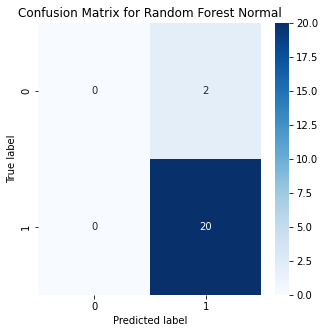

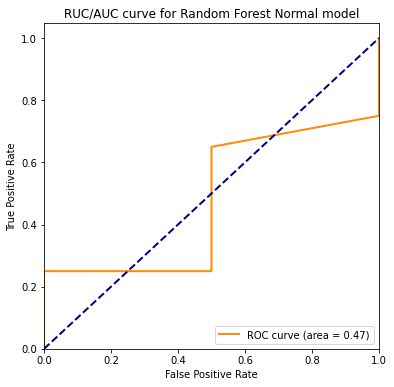

For Random Forest Over
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      0.95      0.93        20

    accuracy                           0.86        22
   macro avg       0.45      0.47      0.46        22
weighted avg       0.82      0.86      0.84        22

Accuracy: 0.91 +/- 0.00
ROC AUC: 0.59 +/- 0.64



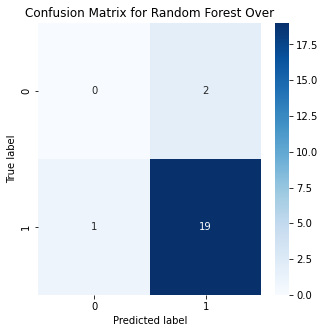

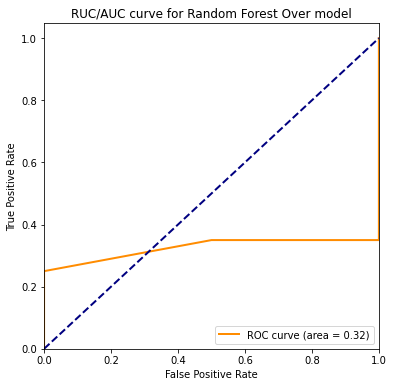

For Random Forest Under
              precision    recall  f1-score   support

           0       0.15      1.00      0.27         2
           1       1.00      0.45      0.62        20

    accuracy                           0.50        22
   macro avg       0.58      0.72      0.44        22
weighted avg       0.92      0.50      0.59        22

Accuracy: 0.91 +/- 0.00
ROC AUC: 0.59 +/- 0.64



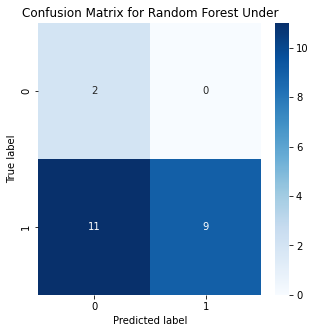

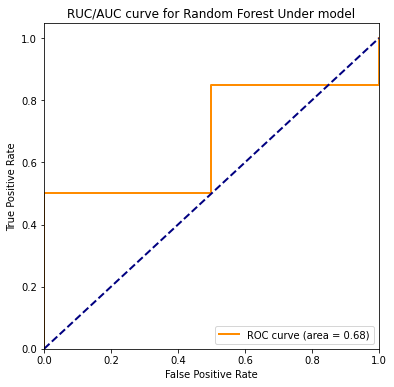

0.675

In [70]:
print("Random Forest")
ClassificationMain(RFNormal,'Random Forest Normal')
ClassificationMain(RFOver,'Random Forest Over')
ClassificationMain(RFUnder,'Random Forest Under')

## 1D CNN

In [71]:

MLPNormal = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
MLPOver = MLPClassifier(random_state=1, max_iter=300).fit(X_train_over, y_train_over)
MLPUnder = MLPClassifier(random_state=1, max_iter=300).fit(X_train_miss, y_train_miss)

test_train_accuracy(MLPNormal,'MLP Normal')
test_train_accuracy(MLPOver,'MLP Over')
test_train_accuracy(MLPUnder,'MLP Under')


Accuracy of MLP Normal classifier on training set: 0.91
Accuracy of MLP Normal classifier on test set: 0.91
Accuracy of MLP Over classifier on training set: 0.84
Accuracy of MLP Over classifier on test set: 0.77
Accuracy of MLP Under classifier on training set: 0.09
Accuracy of MLP Under classifier on test set: 0.14


MLP
For MLP Normal
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      1.00      0.95        20

    accuracy                           0.91        22
   macro avg       0.45      0.50      0.48        22
weighted avg       0.83      0.91      0.87        22

Accuracy: 0.91 +/- 0.00
ROC AUC: 0.50 +/- 0.00



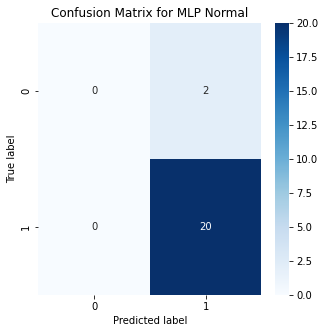

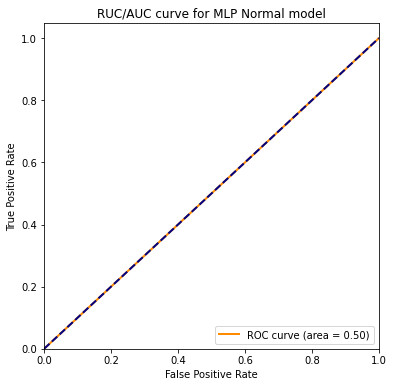

For MLP Over
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      0.85      0.87        20

    accuracy                           0.77        22
   macro avg       0.45      0.42      0.44        22
weighted avg       0.81      0.77      0.79        22

Accuracy: 0.91 +/- 0.00
ROC AUC: 0.50 +/- 0.00



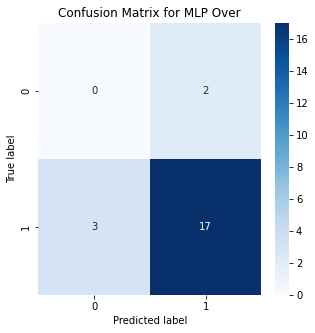

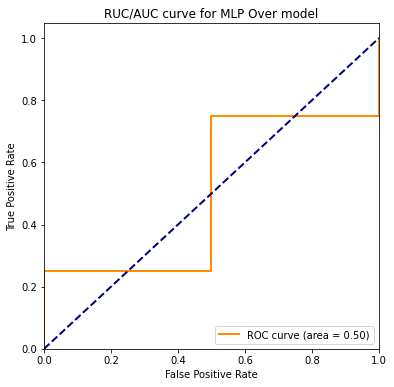

For MLP Under
              precision    recall  f1-score   support

           0       0.10      1.00      0.17         2
           1       1.00      0.05      0.10        20

    accuracy                           0.14        22
   macro avg       0.55      0.53      0.13        22
weighted avg       0.92      0.14      0.10        22

Accuracy: 0.91 +/- 0.00
ROC AUC: 0.50 +/- 0.00



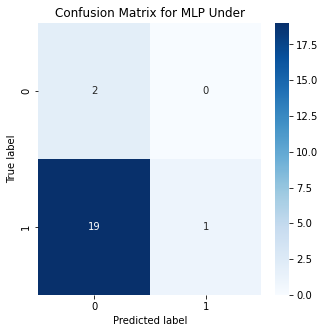

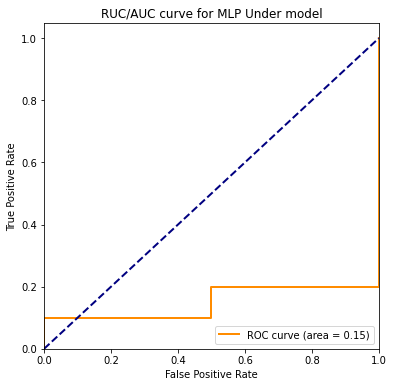

0.15000000000000002

In [72]:
print("MLP")
ClassificationMain(MLPNormal,'MLP Normal')
ClassificationMain(MLPOver,'MLP Over')
ClassificationMain(MLPUnder,'MLP Under')

## GradientBoost


In [73]:
GBNormal= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
GBOver= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_over, y_train_over)
GBUnder= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train_miss, y_train_miss)

test_train_accuracy(GBNormal,'Gradient Boosting Normal')
test_train_accuracy(GBOver,'Gradient Boosting Over')
test_train_accuracy(GBUnder,'Gradient Boosting Under')


Accuracy of Gradient Boosting Normal classifier on training set: 0.96
Accuracy of Gradient Boosting Normal classifier on test set: 0.95
Accuracy of Gradient Boosting Over classifier on training set: 1.00
Accuracy of Gradient Boosting Over classifier on test set: 0.82
Accuracy of Gradient Boosting Under classifier on training set: 0.39
Accuracy of Gradient Boosting Under classifier on test set: 0.41


Gradient Boosting
For Gradient Boosting Normal
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.95      1.00      0.98        20

    accuracy                           0.95        22
   macro avg       0.98      0.75      0.82        22
weighted avg       0.96      0.95      0.95        22

Accuracy: 0.87 +/- 0.28
ROC AUC: 0.77 +/- 0.64



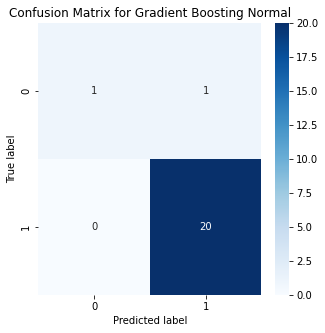

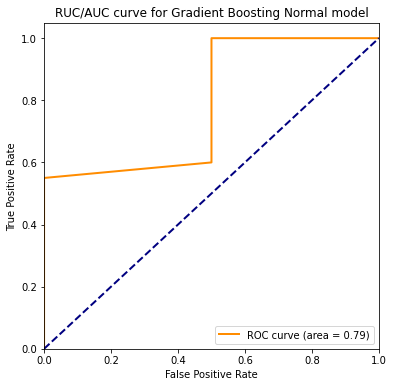

For Gradient Boosting Over
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.94      0.85      0.89        20

    accuracy                           0.82        22
   macro avg       0.60      0.68      0.61        22
weighted avg       0.88      0.82      0.84        22

Accuracy: 0.87 +/- 0.28
ROC AUC: 0.77 +/- 0.64



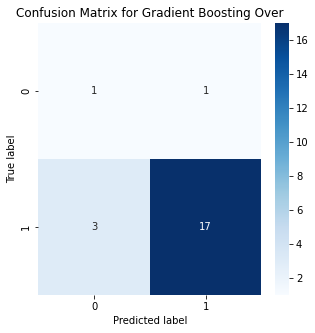

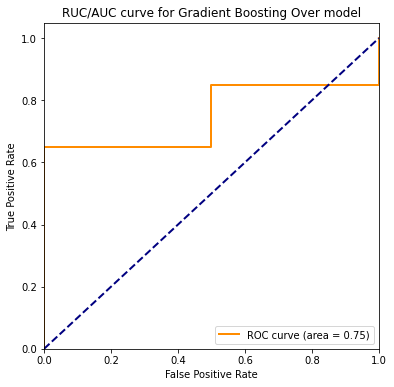

For Gradient Boosting Under
              precision    recall  f1-score   support

           0       0.08      0.50      0.13         2
           1       0.89      0.40      0.55        20

    accuracy                           0.41        22
   macro avg       0.48      0.45      0.34        22
weighted avg       0.82      0.41      0.51        22

Accuracy: 0.87 +/- 0.28
ROC AUC: 0.77 +/- 0.64



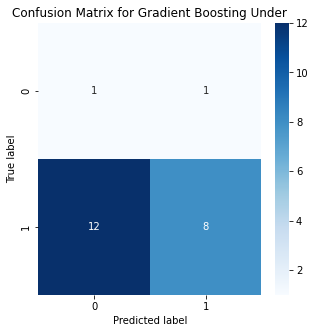

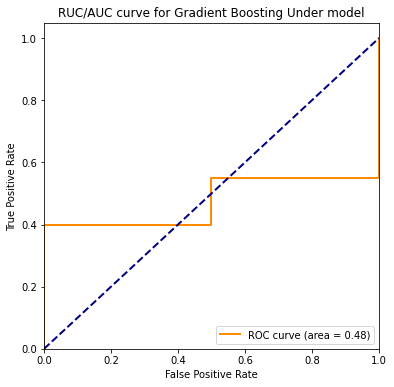

0.47500000000000003

In [74]:
print("Gradient Boosting")
ClassificationMain(GBNormal,'Gradient Boosting Normal')
ClassificationMain(GBOver,'Gradient Boosting Over')
ClassificationMain(GBUnder,'Gradient Boosting Under')

In [75]:

xgbnormal = xgb.XGBClassifier(random_state=1).fit(X_train, y_train)
xgbover = xgb.XGBClassifier(random_state=1).fit(X_train_over, y_train_over)
xgbunder = xgb.XGBClassifier(random_state=1).fit(X_train_miss, y_train_miss)

test_train_accuracy(xgbnormal,'XGB Normal')
test_train_accuracy(xgbover,'XGB Over')
test_train_accuracy(xgbunder,'XGB Under')


Accuracy of XGB Normal classifier on training set: 1.00
Accuracy of XGB Normal classifier on test set: 0.91
Accuracy of XGB Over classifier on training set: 1.00
Accuracy of XGB Over classifier on test set: 0.77
Accuracy of XGB Under classifier on training set: 0.43
Accuracy of XGB Under classifier on test set: 0.41


XGBoost
For XGB Normal
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      1.00      0.95        20

    accuracy                           0.91        22
   macro avg       0.45      0.50      0.48        22
weighted avg       0.83      0.91      0.87        22

Accuracy: 0.88 +/- 0.26
ROC AUC: 0.82 +/- 0.69



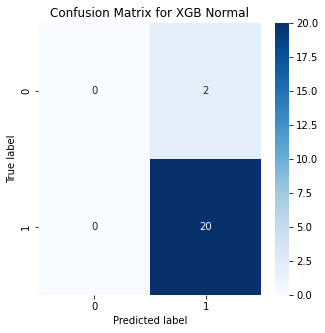

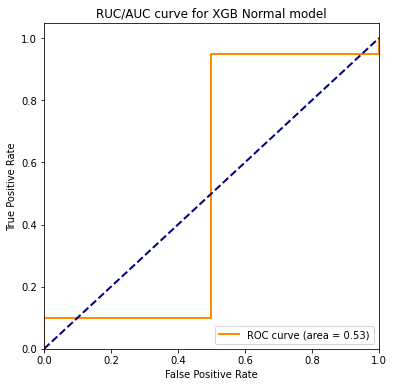

For XGB Over
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.89      0.85      0.87        20

    accuracy                           0.77        22
   macro avg       0.45      0.42      0.44        22
weighted avg       0.81      0.77      0.79        22

Accuracy: 0.88 +/- 0.26
ROC AUC: 0.82 +/- 0.69



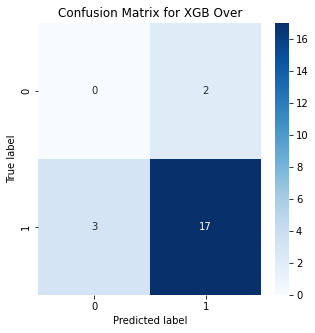

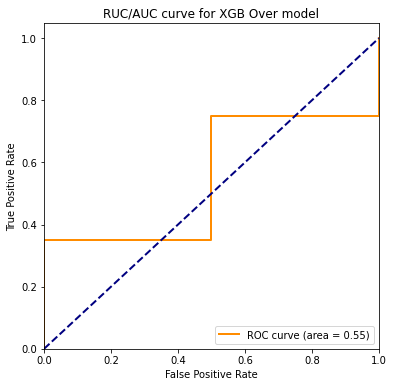

For XGB Under
              precision    recall  f1-score   support

           0       0.13      1.00      0.24         2
           1       1.00      0.35      0.52        20

    accuracy                           0.41        22
   macro avg       0.57      0.68      0.38        22
weighted avg       0.92      0.41      0.49        22

Accuracy: 0.88 +/- 0.26
ROC AUC: 0.82 +/- 0.69



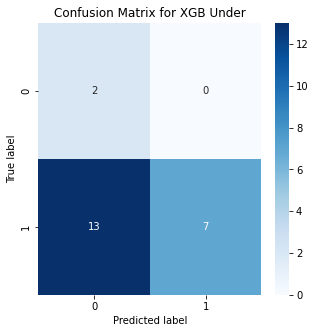

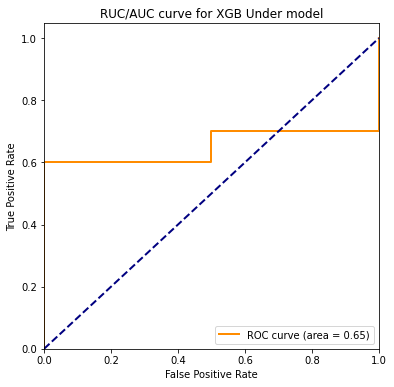

0.6499999999999999

In [76]:
print("XGBoost")
ClassificationMain(xgbnormal,'XGB Normal')
ClassificationMain(xgbover,'XGB Over')
ClassificationMain(xgbunder,'XGB Under')


In [77]:

adaNormal = AdaBoostClassifier(n_estimators=100, random_state=1).fit(X_train, y_train)
adaOver = AdaBoostClassifier(n_estimators=100, random_state=1).fit(X_train_over, y_train_over)
adaUnder = AdaBoostClassifier(n_estimators=100, random_state=1).fit(X_train_miss, y_train_miss)

test_train_accuracy(adaNormal,'AdaBoost Normal')
test_train_accuracy(adaOver,'AdaBoost Over')
test_train_accuracy(adaUnder,'AdaBoost Under')


Accuracy of AdaBoost Normal classifier on training set: 1.00
Accuracy of AdaBoost Normal classifier on test set: 0.86
Accuracy of AdaBoost Over classifier on training set: 1.00
Accuracy of AdaBoost Over classifier on test set: 0.82
Accuracy of AdaBoost Under classifier on training set: 0.38
Accuracy of AdaBoost Under classifier on test set: 0.45


AdaBoost
For AdaBoost Normal
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      0.95      0.93        20

    accuracy                           0.86        22
   macro avg       0.45      0.47      0.46        22
weighted avg       0.82      0.86      0.84        22

Accuracy: 0.91 +/- 0.13
ROC AUC: 0.83 +/- 0.51



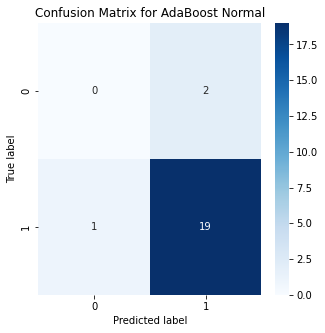

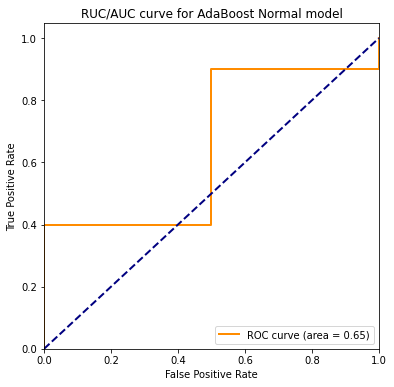

For AdaBoost Over
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      0.90      0.90        20

    accuracy                           0.82        22
   macro avg       0.45      0.45      0.45        22
weighted avg       0.82      0.82      0.82        22

Accuracy: 0.91 +/- 0.13
ROC AUC: 0.83 +/- 0.51



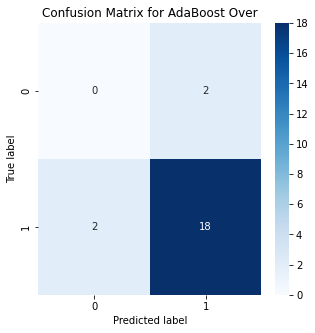

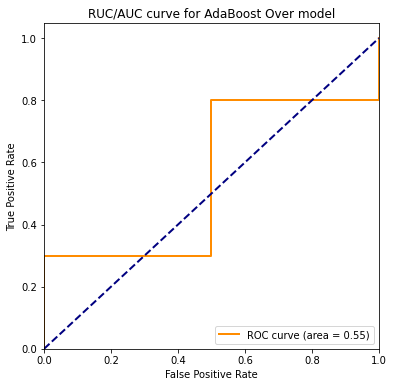

For AdaBoost Under
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         2
           1       1.00      0.40      0.57        20

    accuracy                           0.45        22
   macro avg       0.57      0.70      0.41        22
weighted avg       0.92      0.45      0.54        22

Accuracy: 0.91 +/- 0.13
ROC AUC: 0.83 +/- 0.51



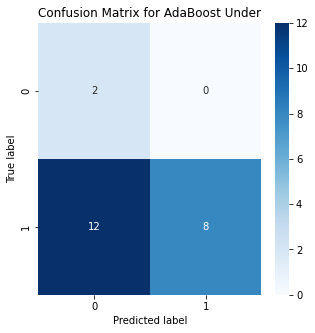

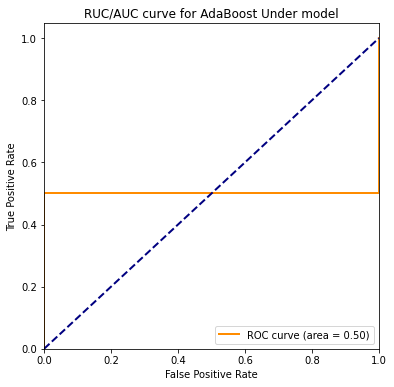

0.5

In [78]:
print("AdaBoost")
ClassificationMain(adaNormal,'AdaBoost Normal')
ClassificationMain(adaOver,'AdaBoost Over')
ClassificationMain(adaUnder,'AdaBoost Under')
